In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install langdetect pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Manage imports
import requests
import pandas as pd
import re
import ast
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Google API - Resource #1
category = "investments"

# law, mythology, lore, magic, neuroscience, sustainability, climate change, innovation, data, internet, blockchain
# cryptocurrency, money, social media, media, communication, agriculture, diy, cooking, food, gardening, crafts,
# photography, survival, travel, transportation, farming, essays, health, fitness, nutrition,
# mental health, meditation, yoga, exercise, diet, ecology, genetics, oceanography, meteorology, 
# noir, contemporary romance, contemporary fiction, western, business, management, marketing, finance, accounting, 
# entrepreneurship, leadership, investing, sales, paranormal, data science, artificial intelligence
# machine learning, programming, software engineering, robotics, web development, networking, cybersecurity, electronics,
# electrical engineering, mechanical engineering, cultural studies, geography, archaeology, sociology

books = []

max_results = 40
start_index = 90

while True:
    params = {
        "q": f"subject:{category}",
        "maxResults": max_results,
        "startIndex": start_index
    }
    
    response = requests.get("https://www.googleapis.com/books/v1/volumes", params=params)
    data = response.json()
    
    items = data.get("items", [])
    if not items:
        break
    
    for item in items:
        volume = item.get("volumeInfo", {})
        search_info = item.get("searchInfo", {})
        book_info = {
            "title": volume.get("title", "N/A"),
            "authors": volume.get("authors", []),
            "publishedDate": volume.get("publishedDate", "N/A"),
            "categories": volume.get("categories", []),
            "description": volume.get("description", "N/A"),
            "averageRating": volume.get("averageRating", "N/A"),
            "textSnippet": search_info.get("textSnippet", "N/A"),
            "language": volume.get("language", "N/A"),
        }
        books.append(book_info)
    
    # get next page
    start_index += max_results

print(f"Total books collected: {len(books)}")

# determine if errors are found in call i.e. max limits per day to call
print(response.status_code, response.url)

if "error" in data:
    print(data["error"])

Total books collected: 30
200 https://www.googleapis.com/books/v1/volumes?q=subject%3Ainvestments&maxResults=40&startIndex=210


In [5]:
# save all work to pdf format - easy traceability
df = pd.DataFrame(books)
df.to_csv(f"../data/google cat csvs/{category}_2.csv", index=False)
print(f"Saved file: {category}.csv")

Saved file: investments.csv


In [6]:
# load all csv files
file_list = []
# correct mapping
folder = "../data/google cat csvs/"
files = [f for f in listdir(folder) if isfile(join(folder, f))]
for file in files:
    path = os.path.join(folder, file)

    # make sure all files attempted exist
    if not os.path.exists(path):
        print(f"File not found: {file}")
        continue
        
    # format for finding path to correct folder for file location
    try:
        # if the file is not empty then append to file_list
        if os.path.getsize(path) > 0:
            df_part = pd.read_csv(path, on_bad_lines='skip')
            file_list.append(df_part)
        
        # if file is empty then send error and file empty
        else:
            print(f"Skip file with no data: {file}")
    except pd.errors.EmptyDataError:
        print(f"Error: file with no data found, {file}")
    except pd.errors.ParserError as e:
        print(f"Error parsing file {file}: {e}")
    except Exception as e:
        print(f"Unexpected error with file {file}: {e}")

# Combine all valid CSVs
if file_list:
    df = pd.concat(file_list, ignore_index=True)
    print(f"Combined files count:{len(file_list)}")

# if no file_list then send error.
else:
    print("Error: CSV files do not exist here")



Unexpected error with file .DS_Store: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
Combined files count:541


In [7]:
# Save everything to csv for tracking purposes
df.to_csv("../data/total_df.csv", index=False)
print(f"Saved file: total_df.csv")

Saved file: total_df.csv


In [8]:
len(df)
# save over this file

35669

In [9]:
# Check DF
print(df.columns.tolist())
df.head()

['title', 'authors', 'publishedDate', 'categories', 'description', 'averageRating', 'textSnippet', 'language', '{']


,title,authors,publishedDate,categories,description,averageRating,textSnippet,language,{
0,Designing and Managing the Supply Chain,"['David Simchi-Levi', 'Philip Kaminsky', 'Edit...",2009,['Business logistics'],"Designing and Managing the Supply Chain, 3/e p...",NaN,NaN,en,NaN
1,Economics,['William A. McEachern'],1994,['Economics'],NaN,NaN,NaN,en,NaN
2,Political Science Is for Everybody,['Amy L. Atchison'],2021-03-31,['Political Science'],This book is the first intersectionality-mains...,NaN,NaN,en,NaN
3,Probability & Statistics for Engineers & Scien...,['Ronald E. Walpole'],2007,['Engineering'],For junior/senior undergraduates taking probab...,NaN,NaN,en,NaN
4,Nonmetals,['Carol Baldwin'],2004-02-23,['Juvenile Nonfiction'],"Examines the properties of nonmetals, the diff...",NaN,NaN,en,NaN


In [10]:
# Kaggle Dataset (https://www.kaggle.com/datasets/abdallahwagih/books-dataset) - Resource #2
df_2 = pd.read_csv("../data/Books_Dataset_Abdallah_Wagih_Ibrahim.csv")
print(df_2.columns.tolist())
df_2.head()

['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories', 'thumbnail', 'description', 'published_year', 'average_rating', 'num_pages', 'ratings_count']


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [11]:
# Function to convert any value to list or default
def convert_value_type(val):
    # Handle missing or NaN values safely
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return []
    if isinstance(val, (list, tuple)):
        return list(val)
    return [word.strip() for word in str(val).split(",") if word.strip()]


# --- Then, fix how you rebuild df_2 ---
# Don’t use df_2[...] as dict keys — use column names as strings
df_2 = pd.DataFrame({
    "title": df_2["title"].fillna("N/A") if "title" in df_2 else "N/A",
    "authors": df_2["authors"].apply(convert_value_type) if "authors" in df_2 else [],
    "categories": df_2["categories"].apply(convert_value_type) if "categories" in df_2 else [],
    "description": df_2["description"].fillna("N/A") if "description" in df_2 else "N/A",
})

df_2.head()

,title,authors,categories,description
0,Gilead,[Marilynne Robinson],[Fiction],A NOVEL THAT READERS and critics have been eag...
1,Spider's Web,[Charles Osborne;Agatha Christie],[Detective and mystery stories],A new 'Christie for Christmas' -- a full-lengt...
2,The One Tree,[Stephen R. Donaldson],[American fiction],Volume Two of Stephen Donaldson's acclaimed se...
3,Rage of angels,[Sidney Sheldon],[Fiction],"A memorable, mesmerizing heroine Jennifer -- b..."
4,The Four Loves,[Clive Staples Lewis],[Christian life],Lewis' work on the nature of love divides love...


In [12]:
# combine Kaggle and google API book lists
df_combined = pd.concat([df, df_2], ignore_index=True)

# Replace all empty values with "N/A"
df_combined = df_combined.astype(object)
df_combined.fillna("N/A", inplace=True)

df_combined.head()

,title,authors,publishedDate,categories,description,averageRating,textSnippet,language,{
0,Designing and Managing the Supply Chain,"['David Simchi-Levi', 'Philip Kaminsky', 'Edit...",2009,['Business logistics'],"Designing and Managing the Supply Chain, 3/e p...",N/A,N/A,en,N/A
1,Economics,['William A. McEachern'],1994,['Economics'],N/A,N/A,N/A,en,N/A
2,Political Science Is for Everybody,['Amy L. Atchison'],2021-03-31,['Political Science'],This book is the first intersectionality-mains...,N/A,N/A,en,N/A
3,Probability & Statistics for Engineers & Scien...,['Ronald E. Walpole'],2007,['Engineering'],For junior/senior undergraduates taking probab...,N/A,N/A,en,N/A
4,Nonmetals,['Carol Baldwin'],2004-02-23,['Juvenile Nonfiction'],"Examines the properties of nonmetals, the diff...",N/A,N/A,en,N/A


In [13]:
# Kaggle Dataset(https://www.kaggle.com/datasets/mdhamani/goodreads-books-100k) - Resource #3
df_3 = pd.read_csv("../data/GoodReads_100k_books.csv")
print(df_3.columns.tolist())
df_3.head()

['author', 'bookformat', 'desc', 'genre', 'img', 'isbn', 'isbn13', 'link', 'pages', 'rating', 'reviews', 'title', 'totalratings']


,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jean Leveille,NaN,"Aujourdâ€™hui, lâ€™oiseau nous invite Ã sa ta...",NaN,https://i.gr-assets.com/images/S/compressed.ph...,2761920813,NaN,https://goodreads.com/book/show/10010880-les-o...,177,4.00,1,Les oiseaux gourmands,1


In [14]:
# Function to convert any value to list or default
def convert_na(val):
    if pd.isnull(val):
        return []
    else : return val

df_3 = pd.DataFrame({
     "title": df_3.get("title").fillna("N/A"),
    "authors": df_3.get("author").apply(convert_na),
    "categories": df_3.get("genre").apply(convert_na),
    "description": df_3.get("desc").fillna("N/A"),
    "averageRating": df_3.get("rating").fillna("N/A"),
})

print(df_3.head())

                                               title  \
0  Between Two Fires: American Indians in the Civ...   
1                           Fashion Sourcebook 1920s   
2                                         Hungary 56   
3  All-American Anarchist: Joseph A. Labadie and ...   
4                              Les oiseaux gourmands   

                            authors  \
0              Laurence M. Hauptman   
1  Charlotte Fiell,Emmanuelle Dirix   
2                     Andy Anderson   
3              Carlotta R. Anderson   
4                     Jean Leveille   

                                          categories  \
0  History,Military History,Civil War,American Hi...   
1          Couture,Fashion,Historical,Art,Nonfiction   
2                                   Politics,History   
3                                      Labor,History   
4                                                 []   

                                         description  averageRating  
0  Reveals that sever

In [15]:
df_combined = pd.concat([df_combined, df_3], ignore_index=True)

# Replace all non-values with "N/A"
df_combined = df_combined.astype(object)
df_combined.fillna("N/A", inplace=True)

print(len(df_combined))
df_combined.head()

142479


,title,authors,publishedDate,categories,description,averageRating,textSnippet,language,{
0,Designing and Managing the Supply Chain,"['David Simchi-Levi', 'Philip Kaminsky', 'Edit...",2009,['Business logistics'],"Designing and Managing the Supply Chain, 3/e p...",N/A,N/A,en,N/A
1,Economics,['William A. McEachern'],1994,['Economics'],N/A,N/A,N/A,en,N/A
2,Political Science Is for Everybody,['Amy L. Atchison'],2021-03-31,['Political Science'],This book is the first intersectionality-mains...,N/A,N/A,en,N/A
3,Probability & Statistics for Engineers & Scien...,['Ronald E. Walpole'],2007,['Engineering'],For junior/senior undergraduates taking probab...,N/A,N/A,en,N/A
4,Nonmetals,['Carol Baldwin'],2004-02-23,['Juvenile Nonfiction'],"Examines the properties of nonmetals, the diff...",N/A,N/A,en,N/A


In [16]:
df_combined.to_csv("../data/total_df.csv", index=False)

In [17]:
# Load your dataset
total_df = pd.read_csv("../data/total_df.csv")

# Drop duplicates by both title and authors
df_clean = total_df.drop_duplicates(subset=["title", "authors"], keep="first")

print(f"Before removing duplicates: {len(total_df)} rows")
print(f"After removing duplicates: {len(df_clean)} rows")

Before removing duplicates: 142479 rows
After removing duplicates: 135243 rows


/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_58684/2028025955.py:2: DtypeWarning: Columns (2,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv("../data/total_df.csv")


In [18]:
# view data
print(len(df_clean))
df_clean.head()


135243


,title,authors,publishedDate,categories,description,averageRating,textSnippet,language,{
0,Designing and Managing the Supply Chain,"['David Simchi-Levi', 'Philip Kaminsky', 'Edit...",2009,['Business logistics'],"Designing and Managing the Supply Chain, 3/e p...",NaN,NaN,en,NaN
1,Economics,['William A. McEachern'],1994,['Economics'],NaN,NaN,NaN,en,NaN
2,Political Science Is for Everybody,['Amy L. Atchison'],2021-03-31,['Political Science'],This book is the first intersectionality-mains...,NaN,NaN,en,NaN
3,Probability & Statistics for Engineers & Scien...,['Ronald E. Walpole'],2007,['Engineering'],For junior/senior undergraduates taking probab...,NaN,NaN,en,NaN
4,Nonmetals,['Carol Baldwin'],2004-02-23,['Juvenile Nonfiction'],"Examines the properties of nonmetals, the diff...",NaN,NaN,en,NaN


In [19]:
# Keep English Language only books for Capstone (simplicity in reviewing)
if "languages" in df_clean.columns:
    # Filter rows where 'languages' contains 'eng'
    df_en = df_clean[df_clean["languages"].apply(lambda x: "eng" in x if isinstance(x, list) else False)]
else:
    print("'languages' column does not exist.")
    df_en = df_clean.copy()  # fallback: keep all rows

def clean_description(text):
    if not isinstance(text, str):
        return ""
    # Keep letters, numbers, spaces, and some punctuation (- . , ? !)
    cleaned = re.sub(r"[^A-Za-z0-9\s\-\.,\?!]", "", text)
    return cleaned

# Apply the function
df_clean.loc[:, 'description'] = df_clean['description'].apply(clean_description)

'languages' column does not exist.


In [20]:
# ensure that all non-English text is removed from description

def is_english(text):
    if not isinstance(text, str) or text.strip() == "":
        return False
    try:
        return detect(text) == "en"
    except:
        return False  # handles empty, short, or malformed text

# Apply language detection and keep only English rows
df_clean["is_english"] = df_clean["description"].apply(is_english)
df_clean = df_clean[df_clean["is_english"]].copy()  # avoid SettingWithCopyWarning

print(f"Remaining rows: {len(df_clean)}")

Remaining rows: 110352


/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_58684/189394630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["is_english"] = df_clean["description"].apply(is_english)


In [21]:
# Normalize authors and Categories (currently list)
def normalize_list(x):
    if isinstance(x, list):
        return x
    # If NaN or empty, return ["N/A"]
    if pd.isnull(x) or x == "":
        return ["N/A"]
    # If a string that looks like a list: "[1, 2, 3]"
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return parsed
    except:
        pass
    # If comma-separated string: "1,2,3"
    return [item.strip() for item in str(x).split(",")]

df_clean = df_clean.copy()  # now it’s independent
df_clean["authors"] = df_clean["authors"].apply(normalize_list)
df_clean["categories"] = df_clean["categories"].apply(normalize_list)




In [22]:
# Keep only meaningful descriptions, authors and titles (all required)
df_clean = df_clean[df_clean["title"].str.len() > 2]
df_clean = df_clean[df_clean["authors"].apply(lambda x: len(x) > 0)]  # at least 1 author
df_clean = df_clean[df_clean["description"].str.len() > 50]
df_clean = df_clean[df_clean["categories"].apply(lambda x:len(x) > 0)]  # at least 1 category

print(len(df_clean))
print(df_clean.head())

101296
                                               title  \
0            Designing and Managing the Supply Chain   
2                 Political Science Is for Everybody   
3  Probability & Statistics for Engineers & Scien...   
4                                          Nonmetals   
5                                           The Cell   

                                             authors publishedDate  \
0  [David Simchi-Levi, Philip Kaminsky, Edith Sim...          2009   
2                                  [Amy L. Atchison]    2021-03-31   
3                                [Ronald E. Walpole]          2007   
4                                    [Carol Baldwin]    2004-02-23   
5                               [Geoffrey M. Cooper]       2018-10   

              categories                                        description  \
0   [Business logistics]  Designing and Managing the Supply Chain, 3e pr...   
2    [Political Science]  This book is the first intersectionality-mains...  

In [23]:
df_clean = df_clean.drop(columns=["averageRating", "is_english"])
# drop date row
df_clean.head()

,title,authors,publishedDate,categories,description,textSnippet,language,{
0,Designing and Managing the Supply Chain,"[David Simchi-Levi, Philip Kaminsky, Edith Sim...",2009,[Business logistics],"Designing and Managing the Supply Chain, 3e pr...",NaN,en,NaN
2,Political Science Is for Everybody,[Amy L. Atchison],2021-03-31,[Political Science],This book is the first intersectionality-mains...,NaN,en,NaN
3,Probability & Statistics for Engineers & Scien...,[Ronald E. Walpole],2007,[Engineering],For juniorsenior undergraduates taking probabi...,NaN,en,NaN
4,Nonmetals,[Carol Baldwin],2004-02-23,[Juvenile Nonfiction],"Examines the properties of nonmetals, the diff...",NaN,en,NaN
5,The Cell,[Geoffrey M. Cooper],2018-10,[Cells],The only 1-semester intro cell biology text bu...,NaN,en,NaN


In [24]:
df_clean["description"].describe()

count                                                101296
unique                                               100476
top       This book was converted from its physical edit...
freq                                                     58
Name: description, dtype: object

In [25]:
# Still seeing duplicates concerning descriptions - must remove description duplicate values
duplicates = df_clean["description"].duplicated()
print(f"Duplicate descriptions: {duplicates.sum()}")
# strip commas from description


df_clean["description"].value_counts().head(10)

Duplicate descriptions: 820


description
This book was converted from its physical edition to the digital format by a community of volunteers. You may find it for free on the web. Purchase of the Kindle edition includes wireless delivery.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [26]:
# remove duplicate descriptions
print(len(df_clean))
df_clean = df_clean.drop_duplicates(subset=["description"]).reset_index(drop=True)
print(len(df_clean))

101296
100476


In [27]:
# How Many Unique Categories currently?
all_categories = [cat for sublist in df_clean["categories"].dropna() for cat in sublist]
unique_categories = set(all_categories)
print(f"Unique Categories Count: {len(unique_categories)}")


Unique Categories Count: 2866


In [28]:
# Normalizing Unique Categories

# ensure that all categories have same casing
normalized_categories = {cat.lower() for cat in unique_categories}
df_clean = df_clean.dropna(subset=["categories"])
df_clean["sub_categories"] = df_clean["categories"].apply(lambda categories: [category.lower() for category in categories])
df_clean.head()

all_categories = [cat for sublist in df_clean["sub_categories"].dropna() for cat in sublist]
unique_categories = set(all_categories)
print(f"Unique Categories Count: {len(unique_categories)}")

Unique Categories Count: 2813


In [29]:
# Normalizing Unique Categories - must reduce to manageable list 

# Begin grouping categories
category_counts = df_clean["sub_categories"].value_counts().reset_index()
category_counts.columns = ["sub_categories", "count"]
print(category_counts)

                                          sub_categories  count
0                                              [fiction]   4381
1                                              [history]   1529
2                                 [business & economics]   1416
3                                     [juvenile fiction]   1091
4                            [biography & autobiography]    871
...                                                  ...    ...
66834       [nonfiction, history, couture, fashion, art]      1
66835  [fantasy, mythology, fantasy, childrens, class...      1
66836  [gardening, reference, nonfiction, art, crafts...      1
66837  [gardening, nonfiction, reference, environment...      1
66838  [nonfiction, history, biography, military hist...      1

[66839 rows x 2 columns]


In [30]:
# Ensure edited_category is always treated as a list
df_clean['sub_categories'] = df_clean['sub_categories'].apply(
    lambda x: x if isinstance(x, list) else [x]
)

# Add a category count column to check up list - remove later
df_clean['category_count'] = df_clean['sub_categories'].apply(len)

# Sort so books with fewer categories come first (1-category books first)
df_clean = df_clean.sort_values(by='category_count', ascending=True).reset_index(drop=True)

# Remove count column
df_clean = df_clean.drop(columns='category_count')

print(df_clean.head())

                                     title  \
0  Designing and Managing the Supply Chain   
1                           Tupolev Tu-144   
2               The Life Monaco Grand Prix   
3                    Eastern Arctic Kayaks   
4                                  Titanic   

                                             authors publishedDate  \
0  [David Simchi-Levi, Philip Kaminsky, Edith Sim...          2009   
1        [Yefim Gordon, E. Gordon, Vladimir Rigmant]          2005   
2                                   [Stuart Codling]    2019-04-16   
3                 [John D. Heath, Eugene Yuji Arima]          2004   
4                                [Thomas E. Bonsall]          1987   

                      categories  \
0           [Business logistics]   
1  [Tupolev 144 (Jet transport)]   
2          [Sports & Recreation]   
3                      [History]   
4               [Transportation]   

                                         description  textSnippet language  \
0  Desi

In [80]:
# balance the grouped categories - work with smaller number of categories in dataset
manual_mapping = {
    'fantasy/horror': ['apocalyptic', 'dark fantasy','horror', 'urban fantasy', 'high fantasy', 'sword and sorcery', 'mythology', 'eldritch', 'eldritch horror', 'grimdark', 'magical realism'],
    'science fiction': ['science fiction', 'scifi', 'sci-fi', 'space opera', 'star trek', 'star wars','extraterrestrial', 'alien', 'first contact', 'time travel', 'robot', 'android', 'cyberpunk', 'dystopian', 'post-apocalyptic', 'futuristic', 'interstellar', 'galactic empire', 'terraforming', 'mecha', 'nanotechnology', 'space exploration'],    
    'romance': ['romance', 'first loves', 'harlequin', 'medieval romance', 'gothic romance', 'georgian romance', 'western historical romance', 'historical romance', 'christian romance', 'chick lit', 'romance', 'love', 'passion'],
    'thriller': ['thriller', 'action', 'crime', 'mystery', 'suspense', 'murder', 'true crime','outlaws', 'spy', 'fiction thriller', 'detective','detective and mystery stories', 'legal thriller','mystery and detective stories', 'paranormal mystery', 'spy thriller','brennan, temperance (fictitious character)', 'cross, alex (fictitious character)','bourne, jason (fictitious character)', 'hannay, richard (fictitious character)','gentry, court (fictitious character)', 'dalziel, andrew (fictitious character)','jack (fictitious character)', 'dance, kathryn (fictitious character)','bates, norman (fictitious character)', 'crusoe, robinson (fictitious character)'],    
    'food': ['cocktails', 'food', 'food writings', 'food studies', 'food essays', 'food allergies', 'cooking', 'food writing', 'food and wine', 'cook','tea', 'coffee', 'beverages', 'vegetarian', 'vegan', 'cookery', 'agriculture','farming', 'gardening', 'gastronomy', 'culinary', 'dining', 'chocolate', 'beer', 'brewing', 'dieting', 'diet', 'alcohol', 'eat', 'dinner', 'breakfast', 'lunch', 'cookbook' ],
    'business/finance': ['business', 'finance', 'finances', 'economics', 'money', 'wealth', 'currency', 'banking', 'banks and banking', 'investment', 'investors', 'venture capital', 'stocks', 'bonds', 'stock market', 'trading', 'cryptocurrency', 'blockchain', 'financial markets', 'economic development', 'entrepreneurship', 'startups', 'management', 'leadership', 'productivity', 'marketing', 'advertising', 'sales', 'commerce', 'retail', 'consumer behavior', 'e-commerce', 'innovation', 'globalization', 'imports', 'exports', 'foreign trade', 'budget', 'taxation', 'accounting', 'auditing', 'contracts', 'corporations', 'executives', 'chief executive officers', 'businesswomen', 'businessmen', 'entrepreneurs', 'negotiation', 'decision making', 'organizational behavior', 'econometrics', 'supply chain', 'logistics', 'management consulting', 'customer service', 'branding', 'human resources', 'employment', 'labor markets', 'job market', 'microeconomics', 'macroeconomics', 'capital', 'capitalism', 'investment strategy', 'financial planning', 'personal finance', 'budgeting', 'savings', 'debt', 'loans', 'mortgages', 'credit', 'insurance', 'risk management', 'real estate', 'property', 'market research', 'business ethics', 'corporate governance', 'innovation strategy','economic theory', 'international business', 'economic policy', 'inflation', 'recession', 'economic growth', 'entrepreneurial finance', 'digital marketing', 'consumer protection', 'advertising strategy', 'fiscal policy', 'monetary policy', 'public finance', 'economic inequality', 'investment banking'],       
    'religion/spirituality': ['bible', 'prayer', 'biblical', 'church', 'islam', 'muslim', 'methodist', 'baptist', 'catholic', 'secularism', 'koran', 'hinduism', 'confucian', 'confucianism','humanism', 'paganism', 'shamanism', 'hinduism', 'old testament', 'new testament', 'christian', 'christianity', 'christian life', 'christian saints', 'apologetics', 'brahmanism', 'amish', 'nātha sect','copts', 'albigenses', 'mormon fundamentalism', 'taoism', 'buddhism','islam', 'mormonism', 'hinduism', 'judaism', 'philosophy', 'theology','clergy', 'holiness', 'religion', 'devotional works', 'spirituality', 'meditation', 'yoga',  'meditation', 'mysticism', 'mystics', 'enlightenment', 'inner peace', 'soul','spirit', 'afterlife', 'karma', 'reincarnation', 'awakening', 'energy healing','occult', 'esoterica', 'alchemy', 'witchcraft', 'magick', 'tarot', 'astrology','crystals', 'aura', 'chakras', 'numerology', 'divination', 'clairvoyance','psychic', 'paranormal', 'ghosts', 'ghost stories', 'haunting', 'mediumship','astral projection', 'new age', 'new age movement', 'holistic', 'reiki', 'wicca','paganism', 'gnosticism', 'metaphysics', 'lucid dreaming', 'law of attraction','manifestation', 'intuition', 'good and evil', 'angels', 'archangels', 'demons','demonology', 'exorcism', 'satanism', 'blessing and cursing', 'yoga', 'zen','taoism', 'buddhist meditation', 'buddist ethics', 'meditation', 'feminist theology','immortality', 'demoniac possession'],   
    'history': ['history', 'battles of','world war', 'pharoahs', 'aztec empire', 'empires', 'roman empire', 'mongolian empire', 'cold war', 'battles', 'atomic bomb', 'world war ii', 'russian revolution', 'war', 'revolution', 'civil war', 'armed forces','emperors', 'genocide',  'ardennes, battle of the, 1944-1945', 'war', 'bombings', 'soldiers','revolution', 'civilization', 'holocaust'],
    'art': ['aesthetics', 'art', 'artist', 'watercolor', 'piano music', 'color theory', 'artists', 'dance', 'ballet',  'sculpting', 'sculpture', 'drawing', 'classical music', 'calligraphy', 'comic books, strips, etc','theater', 'comics', 'comic books', 'antiquities', 'ballets', 'ballet dancers', 'choreography', 'plays','graphic','composition (art)', 'music', 'architectural design', 'painting','graphic novels', 'comic books', 'manga', 'webcomic', 'comic book adaptations', 'comic strips', 'comics & graphic novels', 'graphic novels comics manga', 'drawing','art history', 'photography', 'design', 'architecture', 'film','cinematography', 'animation', 'motion picture industry','film adaptations', 'cinema', 'animated films', 'documentary photography', 'mixed media',],
    'technology': ['technology','computer', 'engineering', 'information technology', 'computation', 'software', 'hardware', 'artificial life', 'feedback control systems', 'algorithms', 'construction projects', 'composite material', 'feedback control systems', 'atomic bomb', 'transportation', 'boatbuilding', 'electric power systems', 'cd-rom diske', 'internet','bearings', 'creep rupture strength', 'cement', 'bent beam test', 'microsoft', 'electronic circuits', '3d optical scanning', 'electric power systems', 'computers', 'computer hackers', 'androids', 'aluminum alloys', 'engineering', 'civil engineering', 'aeronautics', 'automatic test equipment', 'electricity', 'electric circuit analysis', 'electronic apparatus and appliances', 'aviation', 'tupolev 144 (jet transport)', 'access (computer file)', 'c (computer program language)', 'information retrieval', 'client/server computing', 'computer graphics', 'electronics', 'electrical engineering','phones', 'data', 'computer science', 'programming languages', 'software', 'robotics', 'c#', 'arduino', 'database management', 'artificial intelligence'],
    'crafting': ['sewing', 'blacksmith', 'embroidery', 'metalworking', 'origami', 'quilting', 'crafts', 'costume design', 'crafting', 'hobbies', 'hobby', 'crafts & hobbies'],
    'science':['science','comets', 'oceanography', 'chemistry', 'botany', 'microbiology', 'biology', 'quatum', 'meterology', 'mineralogy','disease', 'nurse educators', 'childbirth','medicine', 'human physiology', 'naturopathy', 'anatomy','bacteria','physicists', 'geneticists', 'medical','genes', 'biometrics', 'cellulose', 'surgical intensive care', 'healing', 'aspirin', 'blood banks', 'blood', 'abdomen', 'nervous system', 'bacteriology', 'doctors', 'care of the sick','disabilities', 'metabolism', 'endocrine glands', 'hospital','nursing', 'health',  'traumatology','therapy', 'anatomy', 'physiology', 'cancer', 'amnesia', 'disease', 'fertility', 'human', 'abdominal trauma', 'autism', 'developmental genetics', 'physiotherapy','astronomers','atmosphere', 'interplanetary voyages', 'mars (planet)', 'asteroids',  'physicists', 'genetics','abandoned mines', 'experimental rangelands', 'geomorphology', 'sustainability', 'environment', 'evolution', 'bioethics', 'electrons', 'civil engineering', 'aluminum alloys', 'electrons', 'polysomnography',  'oceanography', 'climate change', 'ecology','astronomy', 'planetary science', 'planets', 'mechanics', 'ecology', 'cosmology', 'global warming','plants', 'dynamic meteorology', 'earth', 'fossil', 'biology', 'chemistry', 'physics', 'geology', 'astronomy', 'alchemists','astronomical instruments', 'ecology', 'zoology', 'paleontology', 'astronomy', 'physics'],

}

# begin to sort the categories mapping above with the categories inside column edited_category to group categories
def mapping(category):
    category_text = ' '.join(category) if isinstance(category, list) else str(category)
    for key, keywords in manual_mapping.items():
        for k in keywords:
            if re.search(rf"\b{re.escape(k)}\b", category_text, re.IGNORECASE) or k.lower() in category_text.lower():
                return key
    return category

df_clean['category_grouped'] = df_clean['sub_categories'].apply(mapping)
df_clean['category_grouped'] = df_clean['category_grouped'].fillna('other').astype('str')

# verify no lists remain
print(df_clean['category_grouped'].apply(type).value_counts())


# need to max out categories in order to balance data - max out at 4000
df_balanced = (
    df_clean
    .groupby('category_grouped', group_keys=False)
    .apply(lambda x: x.sample(n=min(5000, len(x)), random_state=42))
    .reset_index(drop=True)
)

# --- verify results ---
category_counts = df_balanced['category_grouped'].value_counts()
print(category_counts.head(40))
print(f"\nTotal rows after balancing: {len(df_balanced)}")

category_grouped
<class 'str'>    100476
Name: count, dtype: int64


/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_58684/742365562.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(5000, len(x)), random_state=42))


category_grouped
science                          5000
romance                          5000
art                              5000
religion/spirituality            5000
history                          5000
fantasy/horror                   5000
science fiction                  4831
business/finance                 4613
food                             4457
['fiction']                      4381
thriller                         4339
technology                       1436
['juvenile fiction']             1091
['biography & autobiography']     871
crafting                          609
['juvenile nonfiction']           466
['education']                     434
['nonfiction']                    370
['literary criticism']            347
['psychology']                    284
['family & relationships']        214
['drama']                         195
['poetry']                        194
['nature']                        185
['games', 'chess']                177
['law']                          

In [81]:
df_clean.head()
df_balanced.head()

,title,authors,publishedDate,categories,description,textSnippet,language,{,sub_categories,category_grouped
0,And Another Thing--,[Eoin Colfer],2009,"[Adams, Douglas, 1952-2001. Hitchhiker's guide...",An Englishmans continuing search through space...,NaN,en,NaN,"[adams, douglas, 1952-2001. hitchhiker's guide...","[""adams, douglas, 1952-2001. hitchhiker's guid..."
1,Collins-Longman Student Atlas,"[HarperCollins Canada, Limited, HarperCollins ...",2001-01,[Children's atlases],This edition has been revised and up-dated to ...,NaN,en,NaN,[children's atlases],"[""children's atlases""]"
2,Otto Runs for President,[Rosemary Wells],2008,[Children's audiobooks],While the popular Tiffany and athletic Charles...,NaN,en,NaN,[children's audiobooks],"[""children's audiobooks""]"
3,The Random House Children's Encyclopedia,[Ann Kramer],1991,[Children's encyclopedias and dictionaries],A highly illustrated one-volume encyclopedia c...,NaN,en,NaN,[children's encyclopedias and dictionaries],"[""children's encyclopedias and dictionaries""]"
4,Nothing to be Afraid of,[Jan Mark],1982,[Children's fiction],ANTHONY MADE A FRIEND MARROW HILL WILLIAMS VER...,NaN,en,NaN,[children's fiction],"[""children's fiction""]"


In [82]:
# remove all rows that do not fit into the selected categories - I will only keep categories that contain balanced or close 
# to balanced amout of data for my model
# Filter categories with more than 3600 records which is 90% of 4000
valid_categories = df_balanced['category_grouped'].value_counts()
valid_categories = valid_categories[valid_categories > 3600].index

df_balanced = df_balanced[df_balanced['category_grouped'].isin(valid_categories)]



# Final Count for Dataset - number of rows to train model
print(df_balanced['category_grouped'].value_counts())
print(f"\nTotal rows after filtering: {len(df_balanced)}")

category_grouped
art                      5000
fantasy/horror           5000
history                  5000
religion/spirituality    5000
romance                  5000
science                  5000
science fiction          4831
business/finance         4613
food                     4457
['fiction']              4381
thriller                 4339
Name: count, dtype: int64

Total rows after filtering: 52621


In [83]:
# drop all rows with less than 3600 records per category 3600/4000 is 90% 
# this should keep all categories even
valid_categories = df_balanced['category_grouped'].value_counts()
valid_categories = valid_categories[valid_categories > 3600].index

# remove fiction - too broad for dataset
df_balanced = df_balanced[df_balanced['category_grouped'] != "['fiction']"]
df_balanced = df_balanced.reset_index(drop=True)

df_balanced = df_balanced[df_balanced['category_grouped'].isin(valid_categories)]



# Final Count for Dataset - number of rows to train model
print(df_balanced['category_grouped'].value_counts())
print(f"\nTotal rows after filtering: {len(df_balanced)}")

category_grouped
art                      5000
fantasy/horror           5000
history                  5000
religion/spirituality    5000
romance                  5000
science                  5000
science fiction          4831
business/finance         4613
food                     4457
thriller                 4339
Name: count, dtype: int64

Total rows after filtering: 48240


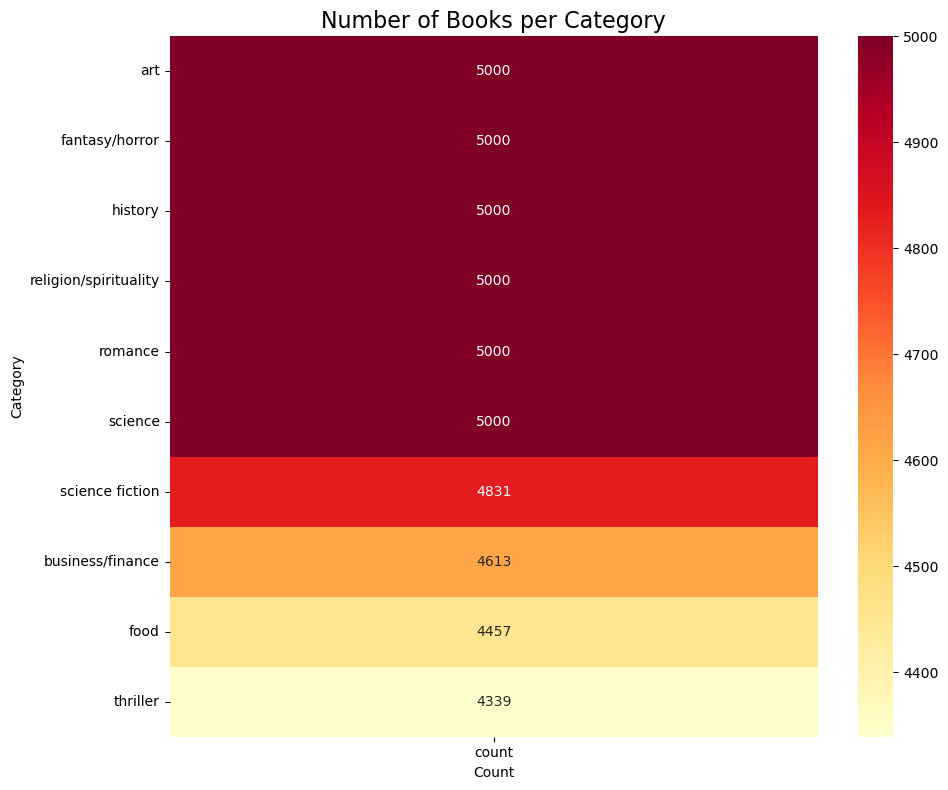

In [84]:
# do a heat map of all the current counts to see balance
heat_data = df_balanced['category_grouped'].value_counts().to_frame(name='count')

plt.figure(figsize=(10, 8))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Number of Books per Category", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

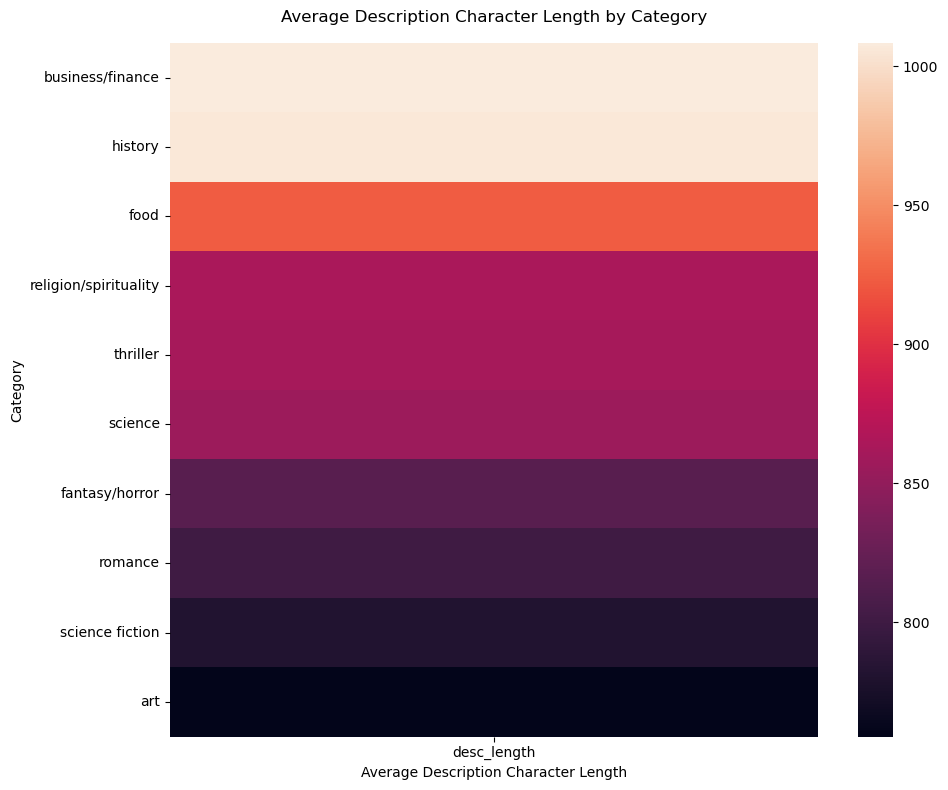

In [85]:
# do heat map concerning the categories vs. the average description character count per category
df_balanced["desc_length"] = df_balanced["description"].astype(str).apply(len)

# Compute the average description length per category
heat_data = df_balanced.groupby("category_grouped")["desc_length"].mean().sort_values(ascending=False).to_frame()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_data)
plt.title("Average Description Character Length by Category",  pad=15)
plt.xlabel("Average Description Character Length")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


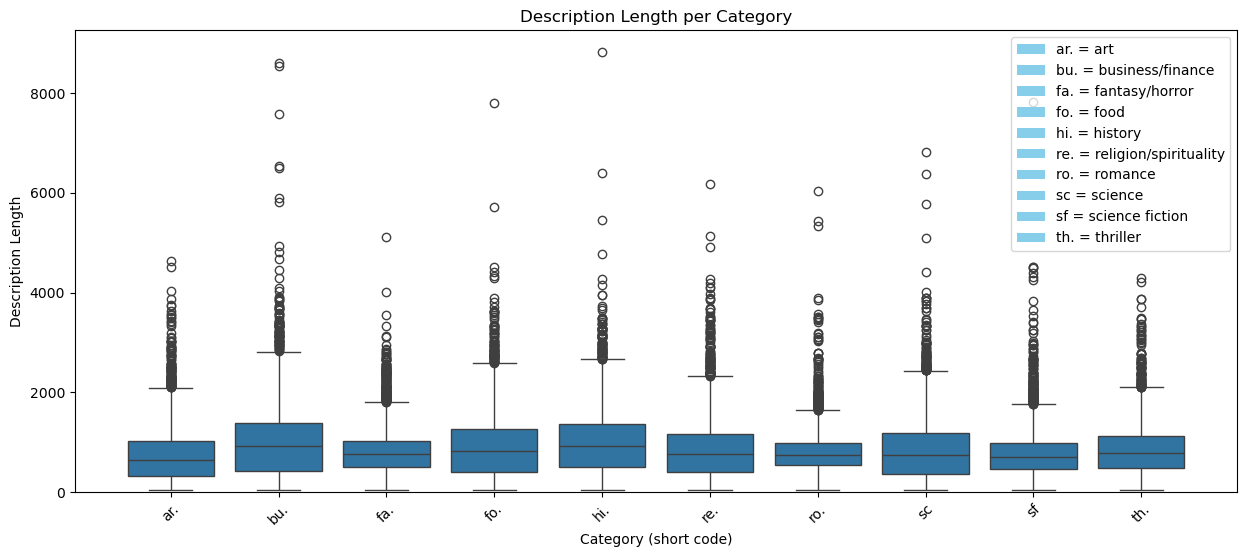

In [86]:
# box chart to visualize description length
df_balanced['category_short'] = df_balanced['category_grouped'].apply(
    lambda x: (
        'sf' if x == 'science fiction' 
        else 'sc' if x == 'science' 
        else x[:2] + '.'
    )
)

# description length
df_balanced['desc_length'] = df_balanced['description'].str.len()

# create the legend
short_mapping = df_balanced[['category_grouped', 'category_short']].drop_duplicates().set_index('category_short')['category_grouped'].to_dict()

# boxplot
plt.figure(figsize=(15,6))
sns.boxplot(data=df_balanced, x='category_short', y='desc_length')

# create legend manually using only unique short codes
for short, full in short_mapping.items():
    plt.bar(0, 0, color='skyblue', label=f"{short} = {full}")  # dummy bars for legend

plt.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel("Description Length")
plt.xlabel("Category (short code)")
plt.title("Description Length per Category")
plt.show()

** Was given guidence that should not remove outliers in description as they were representatives of real data that exist.

From above box chart we see that there are 14 major outliers in the descriptions that should be removed from the data.

2 books from business/finance, 
1 book from fantasy, 
1 book from general fiction, 
2 books from history, 
1 book from humanities, 
2 books from religion, 
1 book from romance, 
2 book from science fiction, 
2 books from spirituality


In [87]:
# Remove excess rows for final version
df_balanced = df_balanced.drop(columns=["category_short", "categories", "{", "textSnippet", "publishedDate", "language"])
df_balanced = df_balanced.rename(columns={'category_grouped': 'category'})

df_balanced.head()

,title,authors,description,sub_categories,category,desc_length
0,"Go Crochet! Afghan Design Workbook: 50 Motifs,...",[Ellen Gormley],Take your crochet on the go!Do your hands itch...,"[crafts, crochet, nonfiction, art, crafts]",art,1056
1,Music is My Mistress,[Duke Ellington],"Music is my mistress, and she plays second fid...","[music, biography, music, jazz, nonfiction, au...",art,1436
2,Picturing History,[Barbara J. Mitnick],This book accompanies the exhibition organized...,[architecture],art,88
3,Film Directing: Cinematic Motion,[Steven D. Katz],The book uses extensive illustrations to expla...,"[culture, film, nonfiction, media tie in]",art,172
4,Batman: The Greatest Stories Ever Told,"[Bill Finger, Denny O'Neil, Bob Kane, Neal Ada...",Just in time for the release of 2005s most ant...,"[sequential art, comics, sequential art, graph...",art,496


In [88]:
# What are the top 5 categories?
most_common_cat = df_balanced["category"].value_counts().head(5)
print(f"Top 5 categories: {most_common_cat}")

# What are the top 5 sub-categories?
most_common_sub = df_balanced["sub_categories"].value_counts().head(5)
print(f"Top 5 sub-categories: {most_common_sub}")
# df_balanced = df_balanced.drop(columns=["category_short", "categories", "{", "textSnippet", "language", "publishedDate", "description_clean"])

df_balanced.head()

Top 5 categories: category
art                      5000
fantasy/horror           5000
history                  5000
religion/spirituality    5000
romance                  5000
Name: count, dtype: int64
Top 5 sub-categories: sub_categories
[business & economics]    1416
[history]                  776
[science]                  642
[medical]                  409
[cooking]                  383
Name: count, dtype: int64


,title,authors,description,sub_categories,category,desc_length
0,"Go Crochet! Afghan Design Workbook: 50 Motifs,...",[Ellen Gormley],Take your crochet on the go!Do your hands itch...,"[crafts, crochet, nonfiction, art, crafts]",art,1056
1,Music is My Mistress,[Duke Ellington],"Music is my mistress, and she plays second fid...","[music, biography, music, jazz, nonfiction, au...",art,1436
2,Picturing History,[Barbara J. Mitnick],This book accompanies the exhibition organized...,[architecture],art,88
3,Film Directing: Cinematic Motion,[Steven D. Katz],The book uses extensive illustrations to expla...,"[culture, film, nonfiction, media tie in]",art,172
4,Batman: The Greatest Stories Ever Told,"[Bill Finger, Denny O'Neil, Bob Kane, Neal Ada...",Just in time for the release of 2005s most ant...,"[sequential art, comics, sequential art, graph...",art,496


In [89]:
# What is the Average description length?
avg_desc = df_balanced["description"].str.len().mean()
print(f"Average Description Length: {avg_desc}")

# What was the smallest description length?
min_desc = df_balanced["description"].str.len().min()
print(f"Description Minimum Length: {min_desc}")

# What was the longest description length?
max_desc = df_balanced["description"].str.len().max()
print(f"Description Maximum Length: {max_desc}")

Average Description Length: 866.2621890547264
Description Minimum Length: 51
Description Maximum Length: 8819


In [90]:
# Save copy of cleaned csv
df_clean.to_csv("../data/books_cleaned.csv", index=False)

# Save copy of balanced data csv
df_balanced['description'] = df_balanced['description'].astype(str).str.replace('\n', ' ').str.strip()
df_balanced['description'] = df_balanced['description'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]+', '', x))
df_balanced['description'] = df_balanced['description'].apply(lambda x: x.lower())
df_balanced.to_csv("../data/final_data_version.csv", index=False)
print(f"Final row count: {len(df_balanced)}")

Final row count: 48240


In [91]:
print(df_balanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48240 entries, 0 to 48239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           48240 non-null  object
 1   authors         48240 non-null  object
 2   description     48240 non-null  object
 3   sub_categories  48240 non-null  object
 4   category        48240 non-null  object
 5   desc_length     48240 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.2+ MB
None


In [44]:
print(df_balanced.sample(5))

                                                   title  \
40829                         Assassin's Creed: Forsaken   
28745  Approval Addiction: Overcoming Your Need to Pl...   
39272                              The Bookman Histories   
14535                                           Monsters   
42381                                          The Forge   

                                authors  \
40829  [Oliver Bowden, Andrew   Holmes]   
28745                     [Joyce Meyer]   
39272                    [Lavie Tidhar]   
14535                    [Ilsa J. Bick]   
42381      [S.M. Stirling, David Drake]   

                                             description  \
40829  assassins creed forsaken is the latest thrilli...   
28745  there is an epidemic of insecurity in society ...   
39272  an omnibus edition of the most exciting steamp...   
14535  the changed are on the move the spared are out...   
42381  long after interstellar civilization collapsed...   

                   

In [45]:
# Implementing machine model in SkLearn to see what the most common words are in each category. 

df_balanced['description'] = df_balanced['description'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]+', '', x))
df_balanced['description'] = df_balanced['description'].apply(lambda x: x.lower())


vectorizer = CountVectorizer(
    stop_words='english',
    max_features=8000, 
    ngram_range=(1,2),
    min_df=75
)
categories = df_balanced['category'].unique()
print(categories)
for category in categories: 
    df_category = df_balanced[df_balanced['category'] == category]
    history = vectorizer.fit_transform(df_category['description'])

    word_counts = history.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    sorted_indices = word_counts.argsort()[::-1]
    top_words = [words[i] for i in sorted_indices[:20]]
    print(f"Top 20 Words for category '{category}': {top_words}")


['art' 'business/finance' 'fantasy/horror' 'food' 'history'
 'religion/spirituality' 'romance' 'science' 'science fiction' 'thriller']
Top 20 Words for category 'art': ['book', 'new', 'art', 'world', 'work', 'design', 'life', 'techniques', 'time', 'including', 'history', 'projects', 'music', 'make', 'years', 'artists', 'guide', 'story', 'collection', 'way']
Top 20 Words for category 'business/finance': ['book', 'new', 'business', 'world', 'people', 'work', 'financial', 'life', 'economic', 'time', 'social', 'make', 'management', 'way', 'money', 'help', 'years', 'change', 'guide', 'shows']
Top 20 Words for category 'fantasy/horror': ['world', 'new', 'life', 'time', 'love', 'book', 'shes', 'just', 'magic', 'story', 'series', 'years', 'dark', 'man', 'like', 'war', 'human', 'power', 'ancient', 'way']
Top 20 Words for category 'food': ['food', 'book', 'recipes', 'new', 'world', 'life', 'make', 'guide', 'cooking', 'wine', 'like', 'garden', 'home', 'best', 'time', 'history', 'way', 'years', 'c

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=3)
clf = MultinomialNB()

In [47]:
X = cv.fit_transform(df_balanced.description)

In [48]:
X

<48981x53907 sparse matrix of type '<class 'numpy.int64'>'
	with 4340358 stored elements in Compressed Sparse Row format>

In [49]:
clf.fit(X, df_balanced.category)

MultinomialNB()

In [50]:
clf.score(X, df_balanced.category)

0.7406545395153222

In [51]:
import numpy as np
imatrix = np.eye(X.shape[1])

In [52]:
probs = clf.predict_proba(imatrix)

In [53]:
probs[0]

array([0.17630475, 0.0661801 , 0.07506037, 0.07111759, 0.06552895,
       0.07647419, 0.0762426 , 0.15809449, 0.1607373 , 0.07425965])

In [54]:
clf.classes_

array(['art', 'business/finance', 'fantasy/horror', 'food', 'history',
       'religion/spirituality', 'romance', 'science', 'science fiction',
       'thriller'], dtype='<U21')

In [55]:
ind = np.argsort(probs[:,0])[::-1]

In [56]:
ind

array([11606, 45961, 38652, ..., 11824, 47552,  8949])

In [57]:
probs[:,0][ind[0]]

0.9440546910281009

In [58]:
words = cv.get_feature_names_out()

In [59]:
ind = np.argsort(probs[:,0])[::-1]
words[ind][:10]

array(['crochet', 'stitches', 'quilting', 'quilts', 'stitch', 'sew',
       'sewing', 'knitted', 'knitters', 'knitting'], dtype=object)

In [60]:
for idx, cl in enumerate(clf.classes_):
    ind = np.argsort(probs[:,idx])[::-1] # this was inside the parenthesis and it needed to be moved out.
    print(ind,probs[:,idx][::-1] )
    top_words = words[ind][:10]
    bottom_words = words[ind][:-10:-1]
    print("Words most associated with class {0}".format(cl))
    for word in top_words:
        print(word)

# min_df raise this and do a search for word and when labeled - order them by prob and see which ones are most probable per class. 

[11606 45961 38652 ... 11824 47552  8949] [0.08579755 0.05916045 0.08585196 ... 0.05119347 0.08238985 0.17630475]
Words most associated with class art
crochet
stitches
quilting
quilts
stitch
sew
sewing
knitted
knitters
knitting
[25251  1316 25255 ...  6509 22347 35171] [0.25764892 0.44414514 0.19335924 ... 0.07686666 0.06185391 0.0661801 ]
Words most associated with class business/finance
investing
accounting
investors
buffett
investment
investor
finance
valuation
entrepreneurship
economists
[ 3561 30704 35898 ...  9383 13893 48176] [0.07305528 0.0503742  0.0731016  ... 0.04359044 0.07015367 0.07506037]
Words most associated with class fantasy/horror
arthurian
mermaid
persephone
arthurs
lancelot
hades
atticus
mages
mage
merlin
[51242 13893 51250 ... 19650 51133  4861] [0.06921782 0.04772814 0.06926172 ... 0.04130072 0.06646864 0.07111759]
Words most associated with class food
vegan
dishes
vegetables
cookbook
recipes
desserts
soups
gardeners
cooking
culinary
[25763 10300 35845 ... 53466

In [61]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
# Split my data
(X_train, X_test, y_train, y_test) = train_test_split(df_balanced.description, df_balanced.category, test_size=0.2, random_state=42)

In [62]:
print(X_train.head())
print(y_train.head())

2453     designed for all those involved in the packagi...
40762    the qwardian known as the weaponer has been co...
26574    this study compares judaism christianity and i...
41656    the wings of fire saga continues with a thrill...
20091    offering an alternative to traditional textboo...
Name: description, dtype: object
2453                       art
40762          science fiction
26574    religion/spirituality
41656          science fiction
20091                  history
Name: category, dtype: object


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

logistic_regression_model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=300))
])

# Report from Logistic Regression testing - Baseline
logistic_regression_model_1.fit(X_train, y_train)
y_pred = logistic_regression_model_1.predict(X_test)
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

                  art       0.58      0.57      0.58      1007
     business/finance       0.77      0.72      0.74       948
       fantasy/horror       0.55      0.58      0.56       959
                 food       0.84      0.69      0.76       875
              history       0.57      0.64      0.60       963
religion/spirituality       0.67      0.65      0.66       997
              romance       0.69      0.78      0.73      1051
              science       0.61      0.63      0.62      1014
      science fiction       0.60      0.56      0.58      1020
             thriller       0.64      0.64      0.64       963

             accuracy                           0.65      9797
            macro avg       0.65      0.65      0.65      9797
         weighted avg       0.65      0.65      0.65      9797



From the Logistic Regression testing we can see that descriptions that likely have the most unique descriptions that enable them to be easily identifyable are business/finance(71% precision), romance(61% precision), spirituality(60% precision) and thriller(59% precision).

The ones that did the weakest in being identified are culture/folklore(31% accuracy), humanities(31% accuracy), general fiction (42% accuracy), and psychology (43% accuracy). This could be due to overlapping words that exist between the genres/categories.



In [65]:
# Attempting once again by upping max_features to 10,000 most common terms
# uping consecutive words 1 to 5 and setting sublinear_tf to true to reduce impact on frequent wording
logistic_regression_model_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 5), sublinear_tf=True)),
    ('clf', LogisticRegression(max_iter=300))
])

# Report from Logistic Regression testing - Baseline
logistic_regression_model_2.fit(X_train, y_train)
y_pred = logistic_regression_model_2.predict(X_test)
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

                  art       0.60      0.60      0.60      1007
     business/finance       0.79      0.72      0.75       948
       fantasy/horror       0.60      0.62      0.61       959
                 food       0.86      0.70      0.77       875
              history       0.58      0.66      0.62       963
religion/spirituality       0.68      0.67      0.68       997
              romance       0.69      0.79      0.74      1051
              science       0.64      0.66      0.65      1014
      science fiction       0.64      0.59      0.62      1020
             thriller       0.66      0.68      0.67       963

             accuracy                           0.67      9797
            macro avg       0.68      0.67      0.67      9797
         weighted avg       0.67      0.67      0.67      9797



In [66]:
# Attempting once again by upping max_features to 10,000 most common terms
# uping consecutive words 1 to 3 and setting sublinear_tf to true to reduce impact on frequent wording
logistic_regression_model_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3), sublinear_tf=True)),
    ('clf', LogisticRegression(max_iter=300))
])

# Report from Logistic Regression testing - Baseline
logistic_regression_model_2.fit(X_train, y_train)
y_pred = logistic_regression_model_2.predict(X_test)
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

                  art       0.60      0.60      0.60      1007
     business/finance       0.79      0.72      0.76       948
       fantasy/horror       0.59      0.61      0.60       959
                 food       0.85      0.70      0.77       875
              history       0.57      0.64      0.60       963
religion/spirituality       0.67      0.65      0.66       997
              romance       0.70      0.78      0.74      1051
              science       0.63      0.65      0.64      1014
      science fiction       0.62      0.59      0.60      1020
             thriller       0.66      0.67      0.67       963

             accuracy                           0.66      9797
            macro avg       0.67      0.66      0.66      9797
         weighted avg       0.67      0.66      0.66      9797



Through increasing the params we see that the bottom categories are now more defined with humanities and culture/folklore still being lower than the others with only slight improvement

In [68]:
# Attempting once again by upping max_features to 20,000 most common terms
# uping consecutive words between 1 and 3 and setting sublinear_tf to true to reduce impact on frequent wording
logistic_regression_model_3 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 3), sublinear_tf=True)),
    ('clf', LogisticRegression(max_iter=300))
])

# Report from Logistic Regression testing - Baseline
logistic_regression_model_3.fit(X_train, y_train)
y_pred = logistic_regression_model_3.predict(X_test)
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

                  art       0.60      0.60      0.60      1007
     business/finance       0.79      0.71      0.75       948
       fantasy/horror       0.60      0.62      0.61       959
                 food       0.86      0.70      0.77       875
              history       0.58      0.66      0.62       963
religion/spirituality       0.68      0.67      0.67       997
              romance       0.69      0.79      0.74      1051
              science       0.64      0.67      0.65      1014
      science fiction       0.64      0.59      0.61      1020
             thriller       0.66      0.68      0.67       963

             accuracy                           0.67      9797
            macro avg       0.68      0.67      0.67      9797
         weighted avg       0.67      0.67      0.67      9797



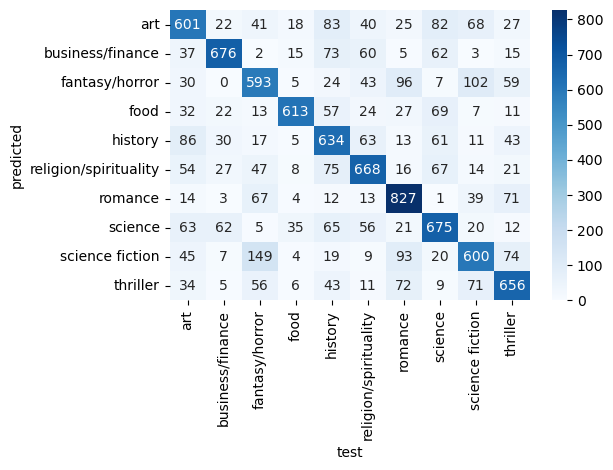

[[601  22  41  18  83  40  25  82  68  27]
 [ 37 676   2  15  73  60   5  62   3  15]
 [ 30   0 593   5  24  43  96   7 102  59]
 [ 32  22  13 613  57  24  27  69   7  11]
 [ 86  30  17   5 634  63  13  61  11  43]
 [ 54  27  47   8  75 668  16  67  14  21]
 [ 14   3  67   4  12  13 827   1  39  71]
 [ 63  62   5  35  65  56  21 675  20  12]
 [ 45   7 149   4  19   9  93  20 600  74]
 [ 34   5  56   6  43  11  72   9  71 656]]


In [69]:
matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)
matrix_p = matrix/matrix.sum(axis=1)
sns.heatmap(matrix, annot=True, fmt = "d", cmap="Blues",yticklabels =clf.classes_,xticklabels=clf.classes_)
plt.title("",  pad=15)
plt.xlabel("test")
plt.ylabel("predicted")
plt.tight_layout()
plt.show()
print(matrix)

In [70]:
clf.classes_

array(['art', 'business/finance', 'fantasy/horror', 'food', 'history',
       'religion/spirituality', 'romance', 'science', 'science fiction',
       'thriller'], dtype='<U21')

Classification Report:

                       precision    recall  f1-score   support

                  art      0.556     0.501     0.527      1007
     business/finance      0.714     0.653     0.682       948
       fantasy/horror      0.554     0.468     0.507       959
                 food      0.793     0.631     0.703       875
              history      0.479     0.585     0.526       963
religion/spirituality      0.586     0.587     0.586       997
              romance      0.561     0.775     0.651      1051
              science      0.549     0.593     0.570      1014
      science fiction      0.613     0.482     0.540      1020
             thriller      0.584     0.601     0.592       963

             accuracy                          0.588      9797
            macro avg      0.599     0.588     0.589      9797
         weighted avg      0.596     0.588     0.587      9797



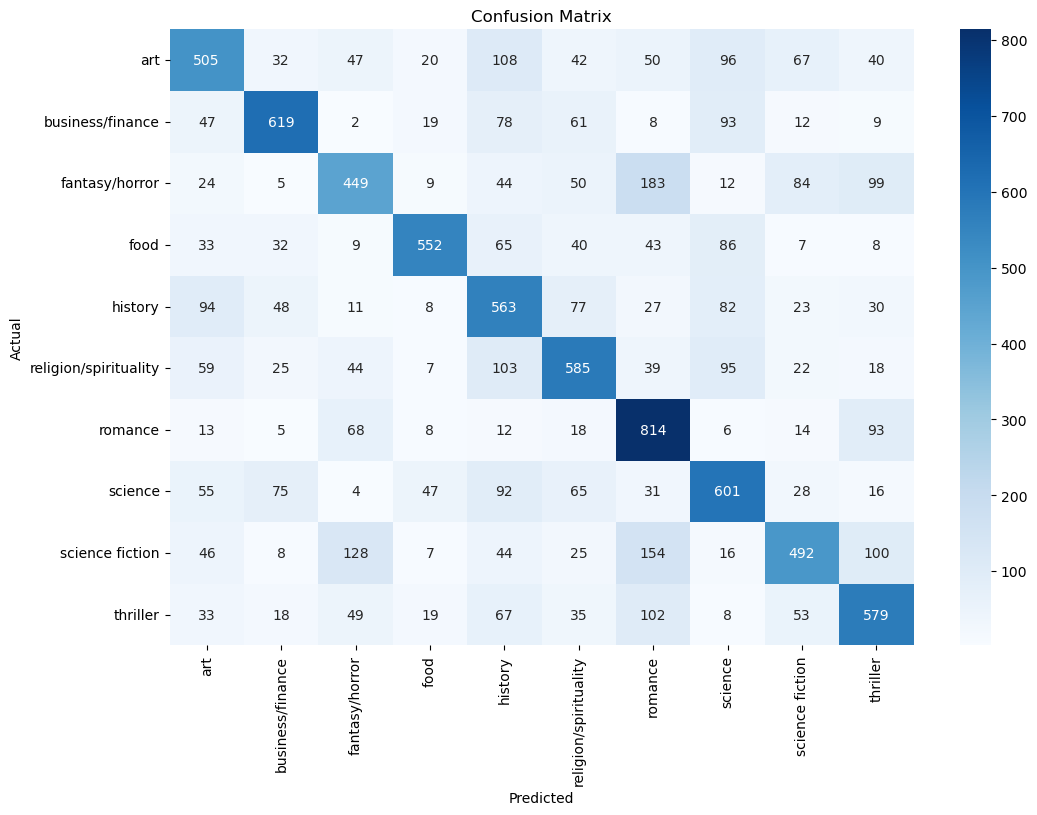

In [71]:
# Random Forest
tfidf = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1,3),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced' 
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=df_balanced['category'].unique(),
            yticklabels=df_balanced['category'].unique(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:

                       precision    recall  f1-score   support

                  art      0.570     0.502     0.534      1007
     business/finance      0.721     0.649     0.683       948
       fantasy/horror      0.548     0.481     0.512       959
                 food      0.801     0.632     0.707       875
              history      0.484     0.616     0.542       963
religion/spirituality      0.572     0.591     0.581       997
              romance      0.562     0.778     0.653      1051
              science      0.561     0.590     0.575      1014
      science fiction      0.603     0.466     0.525      1020
             thriller      0.600     0.598     0.599       963

             accuracy                          0.590      9797
            macro avg      0.602     0.590     0.591      9797
         weighted avg      0.599     0.590     0.590      9797



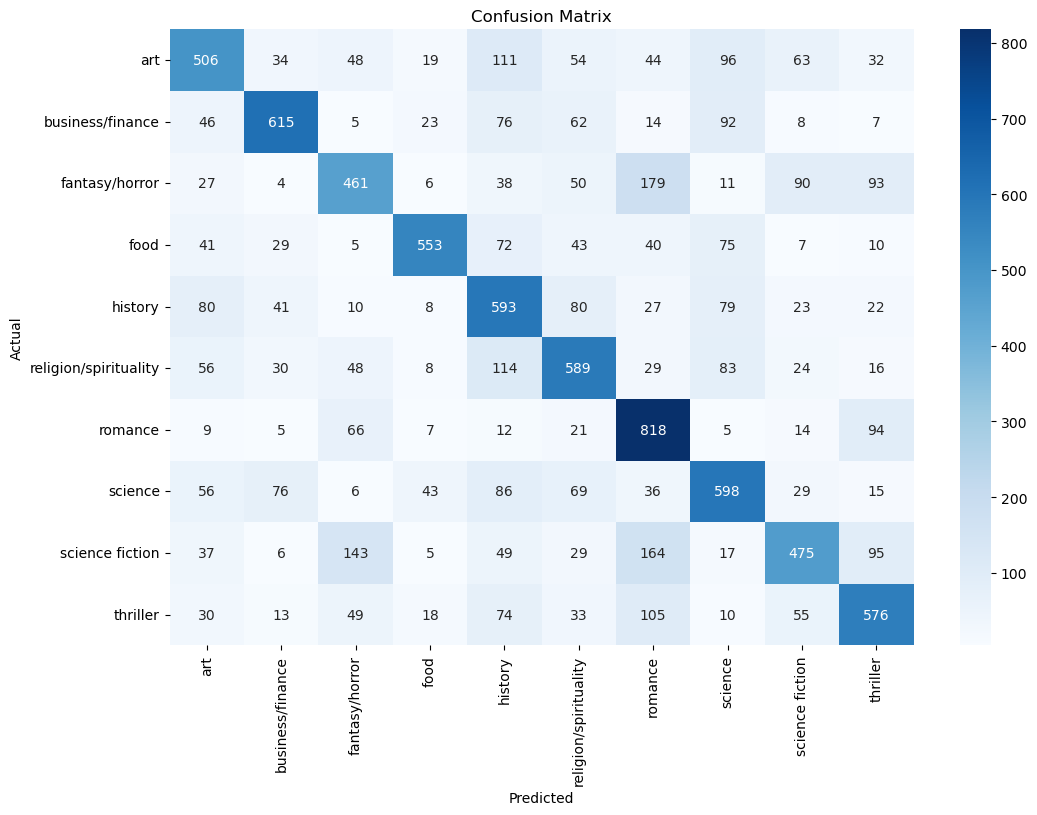

In [72]:
# Random Forest
tfidf = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1,5),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced' 
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_,
            yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:

                       precision    recall  f1-score   support

                  art      0.573     0.507     0.538      1007
     business/finance      0.711     0.641     0.674       948
       fantasy/horror      0.535     0.474     0.503       959
                 food      0.793     0.638     0.707       875
              history      0.484     0.597     0.534       963
religion/spirituality      0.558     0.588     0.572       997
              romance      0.576     0.775     0.661      1051
              science      0.555     0.580     0.567      1014
      science fiction      0.603     0.477     0.533      1020
             thriller      0.589     0.596     0.592       963

             accuracy                          0.588      9797
            macro avg      0.598     0.587     0.588      9797
         weighted avg      0.595     0.588     0.587      9797



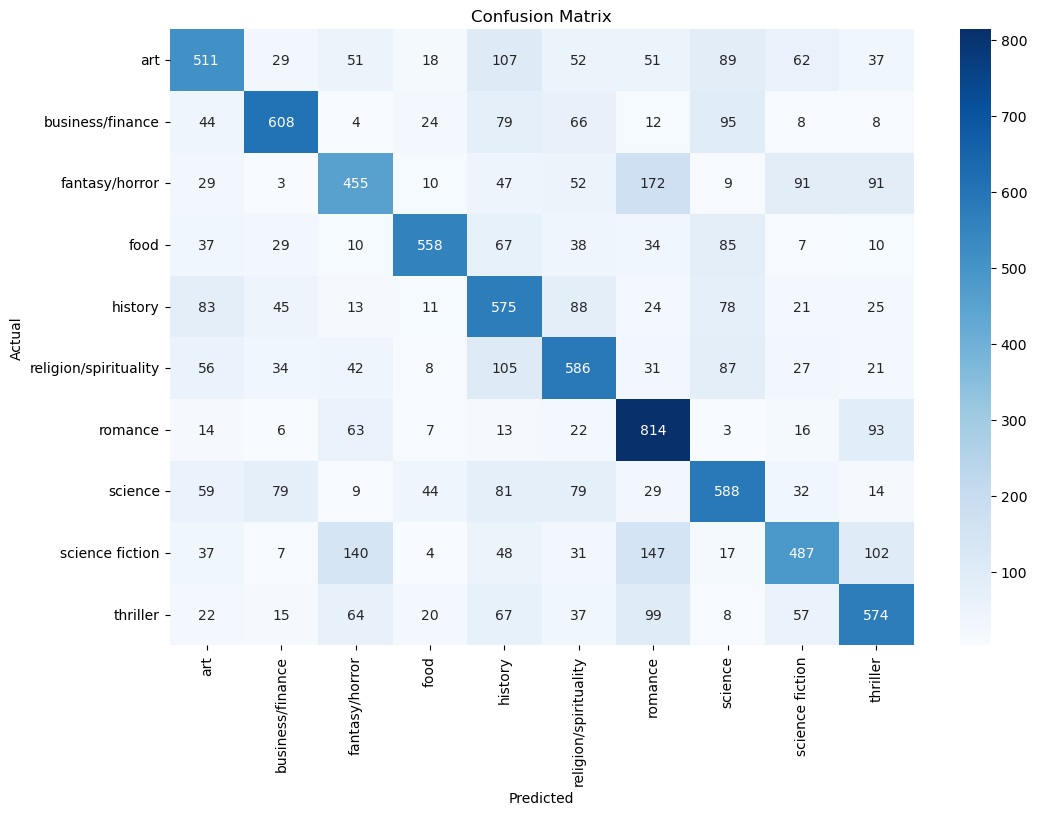

In [73]:
# Random Forest
tfidf = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1,3),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' 
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_,
            yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:

                       precision    recall  f1-score   support

                  art      0.583     0.497     0.536      1007
     business/finance      0.716     0.656     0.685       948
       fantasy/horror      0.559     0.482     0.517       959
                 food      0.799     0.641     0.711       875
              history      0.490     0.606     0.542       963
religion/spirituality      0.570     0.598     0.584       997
              romance      0.568     0.789     0.660      1051
              science      0.567     0.589     0.578      1014
      science fiction      0.610     0.479     0.537      1020
             thriller      0.585     0.602     0.594       963

             accuracy                          0.594      9797
            macro avg      0.605     0.594     0.594      9797
         weighted avg      0.602     0.594     0.593      9797



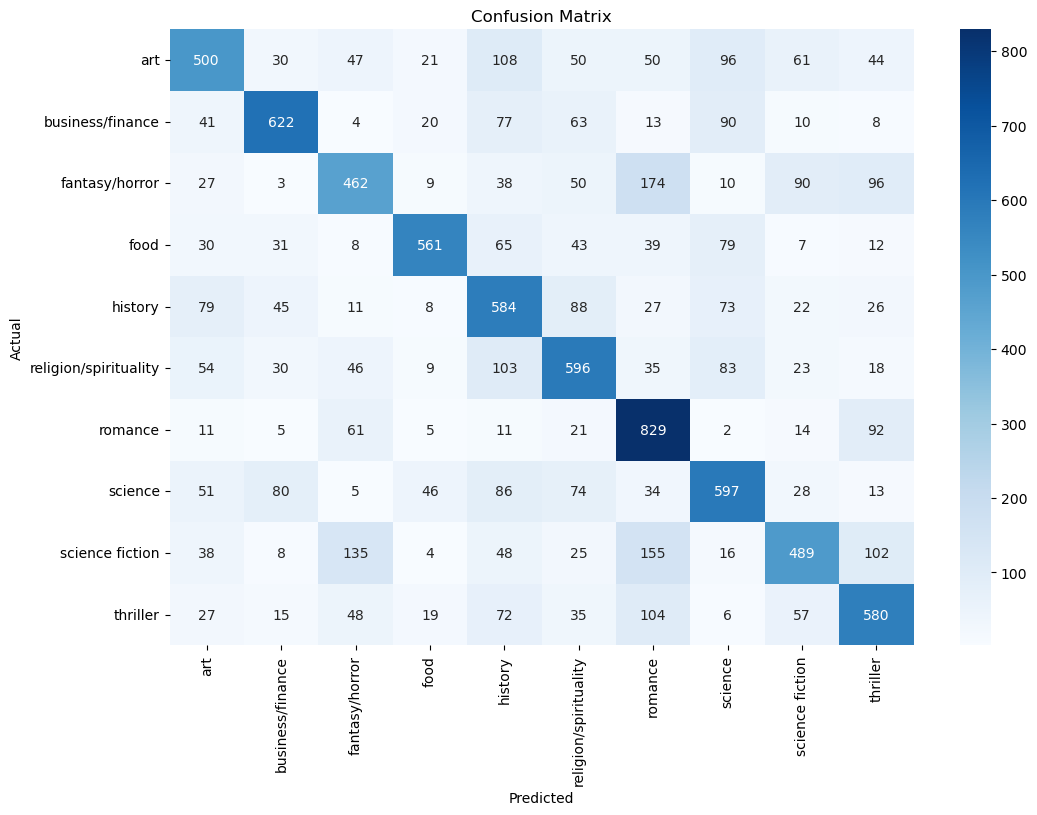

In [74]:
# Random Forest
tfidf = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1,3),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced' 
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_,
            yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:

                       precision    recall  f1-score   support

                  art      0.573     0.507     0.538      1007
     business/finance      0.711     0.641     0.674       948
       fantasy/horror      0.535     0.474     0.503       959
                 food      0.793     0.638     0.707       875
              history      0.484     0.597     0.534       963
religion/spirituality      0.558     0.588     0.572       997
              romance      0.576     0.775     0.661      1051
              science      0.555     0.580     0.567      1014
      science fiction      0.603     0.477     0.533      1020
             thriller      0.589     0.596     0.592       963

             accuracy                          0.588      9797
            macro avg      0.598     0.587     0.588      9797
         weighted avg      0.595     0.588     0.587      9797



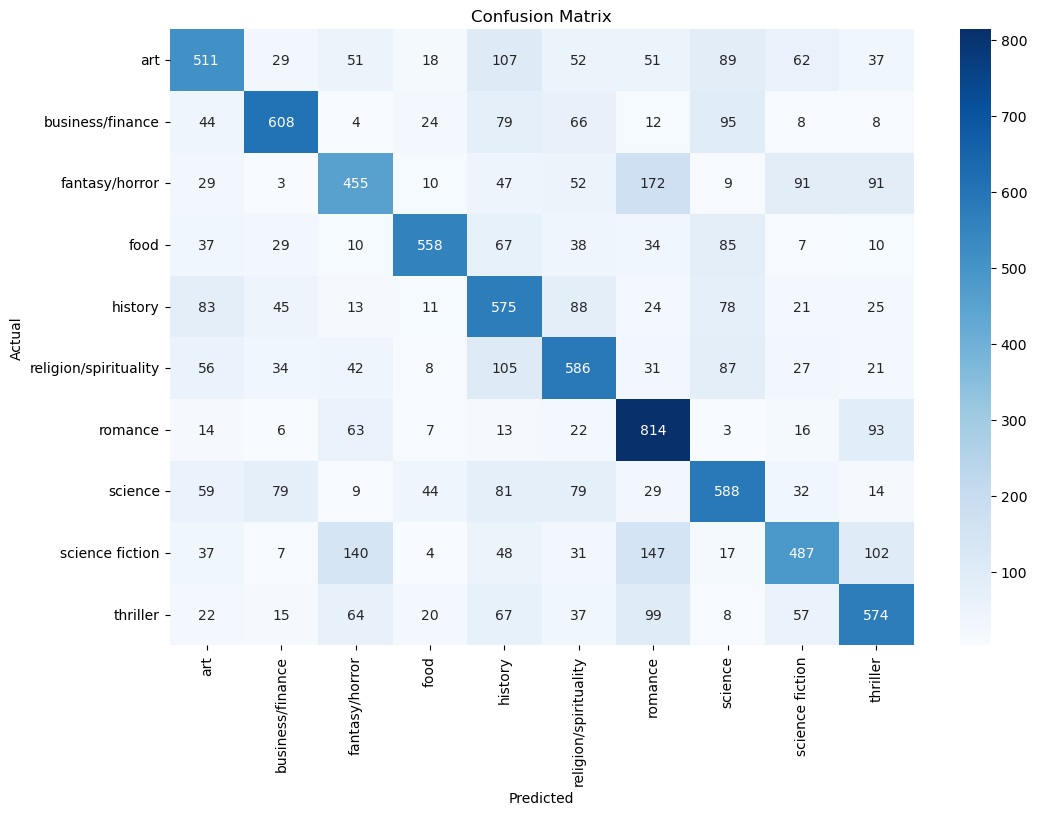

In [75]:
# Random Forest
tfidf = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1,3),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' 
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_,
            yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()